In [164]:
import torch
import torch_geometric
from torch_geometric import utils
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from torch_geometric.nn.models import Node2Vec

from lightgbm import LGBMClassifier

In [165]:
ec_hic = np.load('data/GBM39ec_5k_collapsed_matrix.npy')
hsr_hic = np.load('data/GBM39HSR_5k_collapsed_matrix.npy')

ec_hic = (ec_hic != 0).astype(int)
hsr_hic = np.ones_like(ec_hic)#(hsr_hic != 0).astype(int)

In [166]:
(ec_hic != hsr_hic).sum()

0

In [167]:
# ec_hic = np.load('data/ec_adj_mat.npy')
# hsr_hic = np.load('data/hsr_adj_mat.npy')

# ec_hic = (ec_hic != 0).astype(int)
# hsr_hic = (hsr_hic != 0).astype(int)

# hsr_hic

In [184]:
ec_df = pd.read_csv('data/ec_cleaned.csv')
hsr_df = pd.read_csv('data/hsr_cleaned.csv')

In [185]:
hsr_feats = torch.tensor(hsr_df[['read_count', 'total_genes']].to_numpy())
hsr_labels = torch.zeros(hsr_feats.shape[0])

ec_feats = torch.tensor(ec_df[['read_count', 'total_genes']].to_numpy())
ec_labels = torch.ones(ec_feats.shape[0])

In [186]:
def hic_to_sparse(hic_mat):
    #adj_mat = np.triu(hic_mat)
    sparse_adj = coo_matrix(hic_mat)

    return utils.from_scipy_sparse_matrix(sparse_adj)

In [187]:
hsr_edge_index, hsr_edge_attr = hic_to_sparse(hsr_hic)
hsr_graph = torch_geometric.data.Data(edge_index = hsr_edge_index, edge_attr = hsr_edge_attr, x = hsr_feats, y = hsr_labels)

ec_edge_index, ec_edge_attr = hic_to_sparse(ec_hic)
ec_graph = torch_geometric.data.Data(edge_index = ec_edge_index, edge_attr = ec_edge_attr, x = ec_feats, y = ec_labels)

In [188]:
x = torch.cat([ec_feats, hsr_feats], dim=0)
hsr_edge_index = hsr_edge_index + ec_labels.shape[0]
edge_index = torch.cat([ec_edge_index, hsr_edge_index], dim=1)
edge_attr = torch.cat([ec_edge_attr, hsr_edge_attr], dim=0)
edge_index, edge_attr = utils.to_undirected(edge_index, edge_attr)
labels = torch.cat([ec_labels, hsr_labels], dim=0)

G = torch_geometric.data.Data(edge_index = edge_index, edge_attr = edge_attr, x = x, y = labels)

In [189]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [190]:
def train_one_epoch(node2vec, optimizer, loader):
    node2vec.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def train_node2vec(G, n_epochs=100):
    node2vec = Node2Vec(edge_index=G.edge_index, embedding_dim=16, walk_length=3, context_size=2, walks_per_node=10, num_negative_samples=1, p = 1, q = 1, sparse=True)
    node2vec = node2vec.to(device)
    G = G.to(device)
    
    loader = node2vec.loader(batch_size=128, shuffle=True)
    #loader.edge_weight = G.edge_attr
    optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

    for epoch in range(1, n_epochs+1):
        loss = train_one_epoch(node2vec, optimizer=optimizer, loader=loader)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}')

    node2vec.eval()
    return node2vec().detach().cpu()

In [191]:
embeds = train_node2vec(G, n_epochs=200) 

Epoch: 1, Loss: 3.5240
Epoch: 2, Loss: 3.3464
Epoch: 3, Loss: 3.2787
Epoch: 4, Loss: 3.1389
Epoch: 5, Loss: 3.0453
Epoch: 6, Loss: 3.0160
Epoch: 7, Loss: 2.9500
Epoch: 8, Loss: 2.8288
Epoch: 9, Loss: 2.7212
Epoch: 10, Loss: 2.7124
Epoch: 11, Loss: 2.6127
Epoch: 12, Loss: 2.5069
Epoch: 13, Loss: 2.4913
Epoch: 14, Loss: 2.4027
Epoch: 15, Loss: 2.3183
Epoch: 16, Loss: 2.2729
Epoch: 17, Loss: 2.2317
Epoch: 18, Loss: 2.2140
Epoch: 19, Loss: 2.1472
Epoch: 20, Loss: 2.0799
Epoch: 21, Loss: 2.0450
Epoch: 22, Loss: 1.9910
Epoch: 23, Loss: 1.9560
Epoch: 24, Loss: 1.9362
Epoch: 25, Loss: 1.8773
Epoch: 26, Loss: 1.8353
Epoch: 27, Loss: 1.7967
Epoch: 28, Loss: 1.7763
Epoch: 29, Loss: 1.7287
Epoch: 30, Loss: 1.7169
Epoch: 31, Loss: 1.6672
Epoch: 32, Loss: 1.6745
Epoch: 33, Loss: 1.6528
Epoch: 34, Loss: 1.5977
Epoch: 35, Loss: 1.5733
Epoch: 36, Loss: 1.5583
Epoch: 37, Loss: 1.5054
Epoch: 38, Loss: 1.5043
Epoch: 39, Loss: 1.4763
Epoch: 40, Loss: 1.4614
Epoch: 41, Loss: 1.4421
Epoch: 42, Loss: 1.4266
E

In [192]:
feats_and_embeds = embeds#torch.cat([embeds, x], dim=1)

In [193]:
X = feats_and_embeds.numpy()
y = G.y.cpu().numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [194]:
mdl = LogisticRegression(solver='liblinear')
mdl.fit(X_train, y_train)

preds = mdl.predict(X_test)
(preds == y_test).mean()

1.0

In [195]:
lgb = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    num_leaves=63,
    learning_rate=0.1,
    n_estimators=500
)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

[LightGBM] [Info] Number of positive: 173, number of negative: 178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1888
[LightGBM] [Info] Number of data points in the train set: 351, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492877 -> initscore=-0.028492
[LightGBM] [Info] Start training from score -0.028492
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [196]:
(y_pred == y_test).mean()

1.0

In [197]:
from sklearn.decomposition import PCA

embeds = feats_and_embeds
pca = PCA(n_components=2)
pca_embeds = pca.fit_transform(embeds)
pca_embeds.shape

(502, 2)

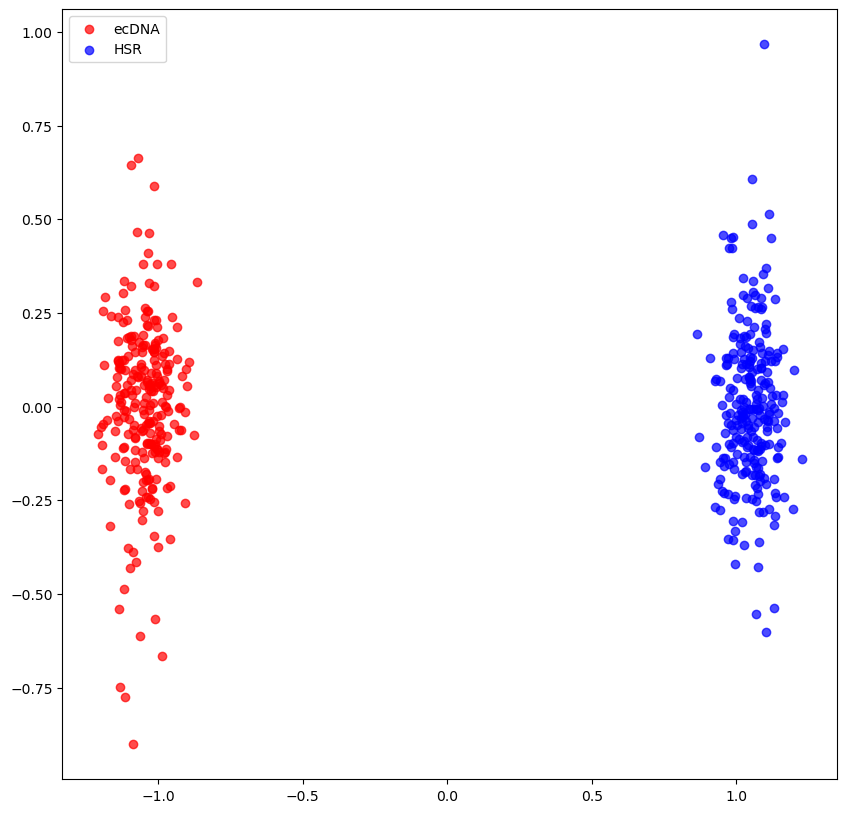

In [198]:
import matplotlib.pyplot as plt

ec_mask = (G.y == 1).cpu()

plt.figure(figsize=(10,10))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.7)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.7)
plt.legend()
plt.show()